In [1]:
# Cargar librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def get_cuota(monto, tasa, meses):
    return monto * (tasa * (1 + tasa) ** meses) / ((1 + tasa) ** meses - 1)

In [3]:
def calcular_amortizacion(monto, tasa, meses, aumento_cuota = 0):
    """
    Calcula una tabla de amortización con sistema francés (cuota fija).

    Parámetros:
    - monto: Monto total del préstamo
    - tasa: Tasa de interés anual (en porcentaje, ej. 5 para 5%)
    - meses: Plazo total en meses

    Retorna:
    - DataFrame con la tabla de amortización
    """

    tasa_mensual = tasa / 12 / 100
    cuota = get_cuota(monto, tasa_mensual, meses)
    cuota = round(cuota * (1 + aumento_cuota / 100), 3)

    saldo = monto
    tabla = []

    for mes in range(1, meses + 1):
        interes = saldo * tasa_mensual
        amortizacion = cuota - interes
        saldo -= amortizacion

        tabla.append({
            'mes': mes,
            'cuota': round(cuota, 3),
            'interes': round(interes, 3),
            'amortizacion': round(amortizacion, 3),
            'saldo_pendiente': round(max(saldo, 0), 3)
        })
    # Crear un DataFrame con la tabla de amortización
    df = pd.DataFrame(tabla)
    df['interes_acumulado'] = df['interes'].cumsum()

    # Si se paga antes de tiempo, eliminar las filas restantes
    # Encuentra el índice de la primera fila donde 'saldo_pendiente' <= 0
    primer_idx = df[df['saldo_pendiente'] <= 0].index.min()

    # Filtra el DataFrame hasta esa fila (inclusive)
    df = df.loc[:primer_idx] if primer_idx is not None else df

    # Calcular cuota final modificada
    if primer_idx is not None and primer_idx > 0:
        # Calcular la cuota final
        df.loc[primer_idx, 'cuota'] = df.loc[primer_idx - 1, 'saldo_pendiente'] * ( 1 + tasa_mensual) 
        # Ajustar el saldo pendiente a cero
        # df.loc[primer_idx, 'saldo_pendiente'] = 0
        # Ajustar la amortización y el interés de la última cuota
        df.loc[primer_idx, 'amortizacion'] = df.loc[primer_idx, 'cuota'] - df.loc[primer_idx, 'interes']

    return df

In [4]:
def plot_amortizacion(df_amortizacion, color, interes_acumulados_inicial=0, meses_inicial=0,aumento=0, ax=None):
    """
    Grafica la tabla de amortización.

    Parámetros:
    - df_amortizacion: DataFrame con la tabla de amortización
    """

    if ax is None:
        ax = plt.gca()
    
    if aumento == 0:
        ax.plot(df_amortizacion['mes'], df_amortizacion['saldo_pendiente'], label='saldo cuota inicial', color = color, linewidth=2.5);
        ax.plot(df_amortizacion['mes'], df_amortizacion['interes_acumulado'], label='intereses_acumulados', color = 'red');
    else:
        # Calcular mejora en intereses acumulados
        dif_interes_acumulado = interes_acumulados_inicial - df_amortizacion['interes_acumulado'].tail(1).values[0] 
        porc_interes_acumulado = (dif_interes_acumulado / interes_acumulados_inicial) * 100
        
        dif_meses = meses_inicial - df_amortizacion['mes'].tail(1).values[0]
        # porc_meses = (dif_meses / meses_inicial) * 100

        label = f'saldo de cuota+{aumento}%: ahorro de {round(dif_interes_acumulado, 2)}€ que representa un {round(porc_interes_acumulado, 2)}%  en intereses y {round(dif_meses, 2)} meses menos'
        ax.plot(df_amortizacion['mes'], df_amortizacion['saldo_pendiente'], label=label, color = color);
    ax.set_xlabel('meses')
    ax.set_ylabel('monto')
    ax.grid(linewidth=0.3)
    # plt.grid(linewidth=.3)
    # plt.xlabel('meses')
    # plt.ylabel('Monto')
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.tight_layout()
    # plt.show()


In [5]:
def pipeline(monto, tasa, meses):

    # Obtener la tabla de amortizacion inicial 
    ###################
    df_amortizacion = calcular_amortizacion(monto, tasa, meses)
    interes_acumulado_inicial = df_amortizacion['interes_acumulado'].tail(1).values[0]
    meses_inicial = df_amortizacion['mes'].tail(1).values[0]
    cuota_inicial = df_amortizacion['cuota'].tail(1).values[0]

    # Obtener escenarios
    ###################
    escenarios = {}
    for aumento in range(10, 101, 10):
        df_amortizacion_esces = df_amortizacion.copy()
        # print(f"Escenario {aumento}%")
        escenarios[aumento] = calcular_amortizacion(monto=monto, tasa=tasa, meses=meses, aumento_cuota=aumento)

    # Graficar la tabla de amortización para los diferentes escenarios
    ###################
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm

    # Crear la figura
    # plt.figure(figsize=(14, 7))
    fig, ax = plt.subplots(figsize=(18, 9), constrained_layout=False)

    # Graficar el escenario base (color fijo)
    plot_amortizacion(df_amortizacion, color = 'purple')

    # Crear el degradado de color basado en la cantidad de escenarios
    valores = list(escenarios.keys())
    norm = mcolors.Normalize(vmin=min(valores), vmax=max(valores))
    cmap = cm.get_cmap('viridis')  # Puedes probar otros como 'viridis', 'coolwarm', etc.

    # Graficar los escenarios con colores degradados
    for k, v in escenarios.items():
        color = cmap(norm(k))
        plot_amortizacion(df_amortizacion = v, aumento = k, color = color, interes_acumulados_inicial=interes_acumulado_inicial, meses_inicial=meses_inicial)

    # Ajuste manual de espacio
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])  # reduce el ancho del gráfico para dejar sitio a la leyenda

    # Poner la leyenda *fuera* del área del gráfico
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.title(f'Simulación de amortización con cuota fija\nMonto: {monto} | Tasa: {tasa}% | Plazo: {meses} meses | Cuota: {cuota_inicial:.2f}', fontsize=16)

    plt.show()

    return df_amortizacion, escenarios


/var/folders/8c/_kn82sm11xg_1xzyn7clzt1w0000gn/T/ipykernel_56989/914131256.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')  # Puedes probar otros como 'viridis', 'coolwarm', etc.


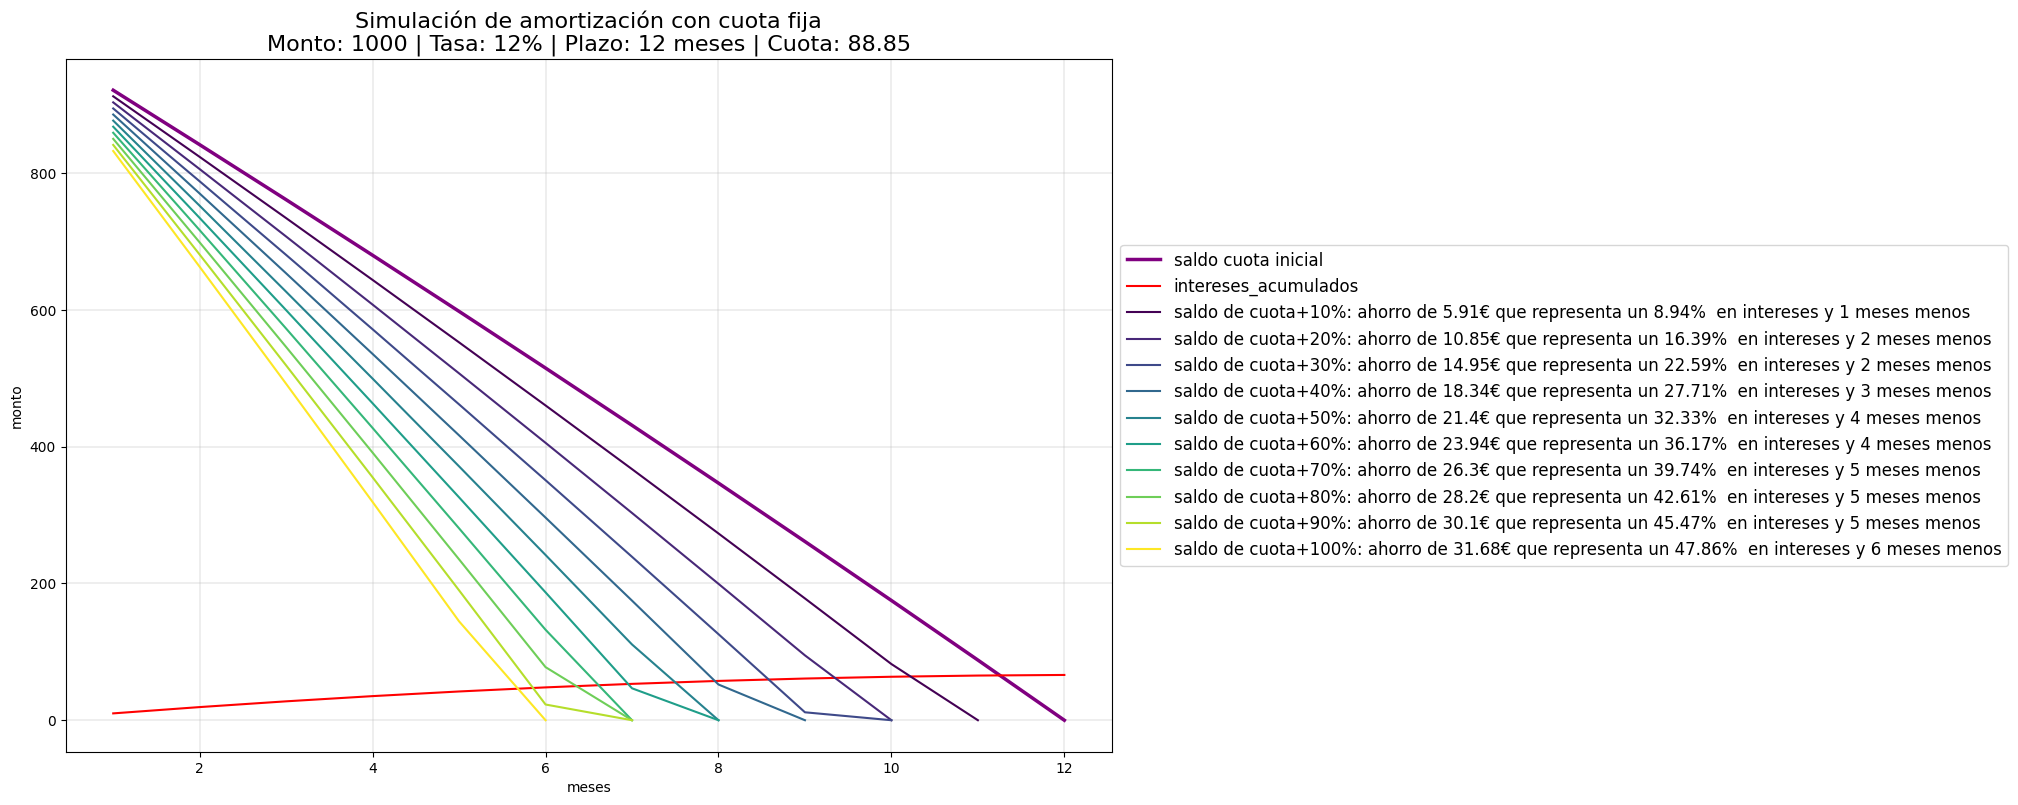

In [6]:
# Ejercicio de juguete
TASA = 12
MONTO = 1000
MESES = 12

df_amortizacion, escenarios = pipeline(MONTO, TASA, MESES)

In [7]:
df_amortizacion

,mes,cuota,interes,amortizacion,saldo_pendiente,interes_acumulado
0,1,88.84900,10.000,78.84900,921.151,10.000
1,2,88.84900,9.212,79.63700,841.514,19.212
2,3,88.84900,8.415,80.43400,761.080,27.627
3,4,88.84900,7.611,81.23800,679.841,35.238
4,5,88.84900,6.798,82.05100,597.791,42.036
5,6,88.84900,5.978,82.87100,514.920,48.014
6,7,88.84900,5.149,83.70000,431.220,53.163
7,8,88.84900,4.312,84.53700,346.683,57.475
8,9,88.84900,3.467,85.38200,261.301,60.942
9,10,88.84900,2.613,86.23600,175.065,63.555


In [8]:
escenarios[10]

,mes,cuota,interes,amortizacion,saldo_pendiente,interes_acumulado
0,1,97.73400,10.000,87.73400,912.266,10.000
1,2,97.73400,9.123,88.61100,823.655,19.123
2,3,97.73400,8.237,89.49700,734.157,27.360
3,4,97.73400,7.342,90.39200,643.765,34.702
4,5,97.73400,6.438,91.29600,552.468,41.140
5,6,97.73400,5.525,92.20900,460.259,46.665
6,7,97.73400,4.603,93.13100,367.128,51.268
7,8,97.73400,3.671,94.06300,273.065,54.939
8,9,97.73400,2.731,95.00300,178.062,57.670
9,10,97.73400,1.781,95.95300,82.108,59.451


/var/folders/8c/_kn82sm11xg_1xzyn7clzt1w0000gn/T/ipykernel_56989/914131256.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')  # Puedes probar otros como 'viridis', 'coolwarm', etc.


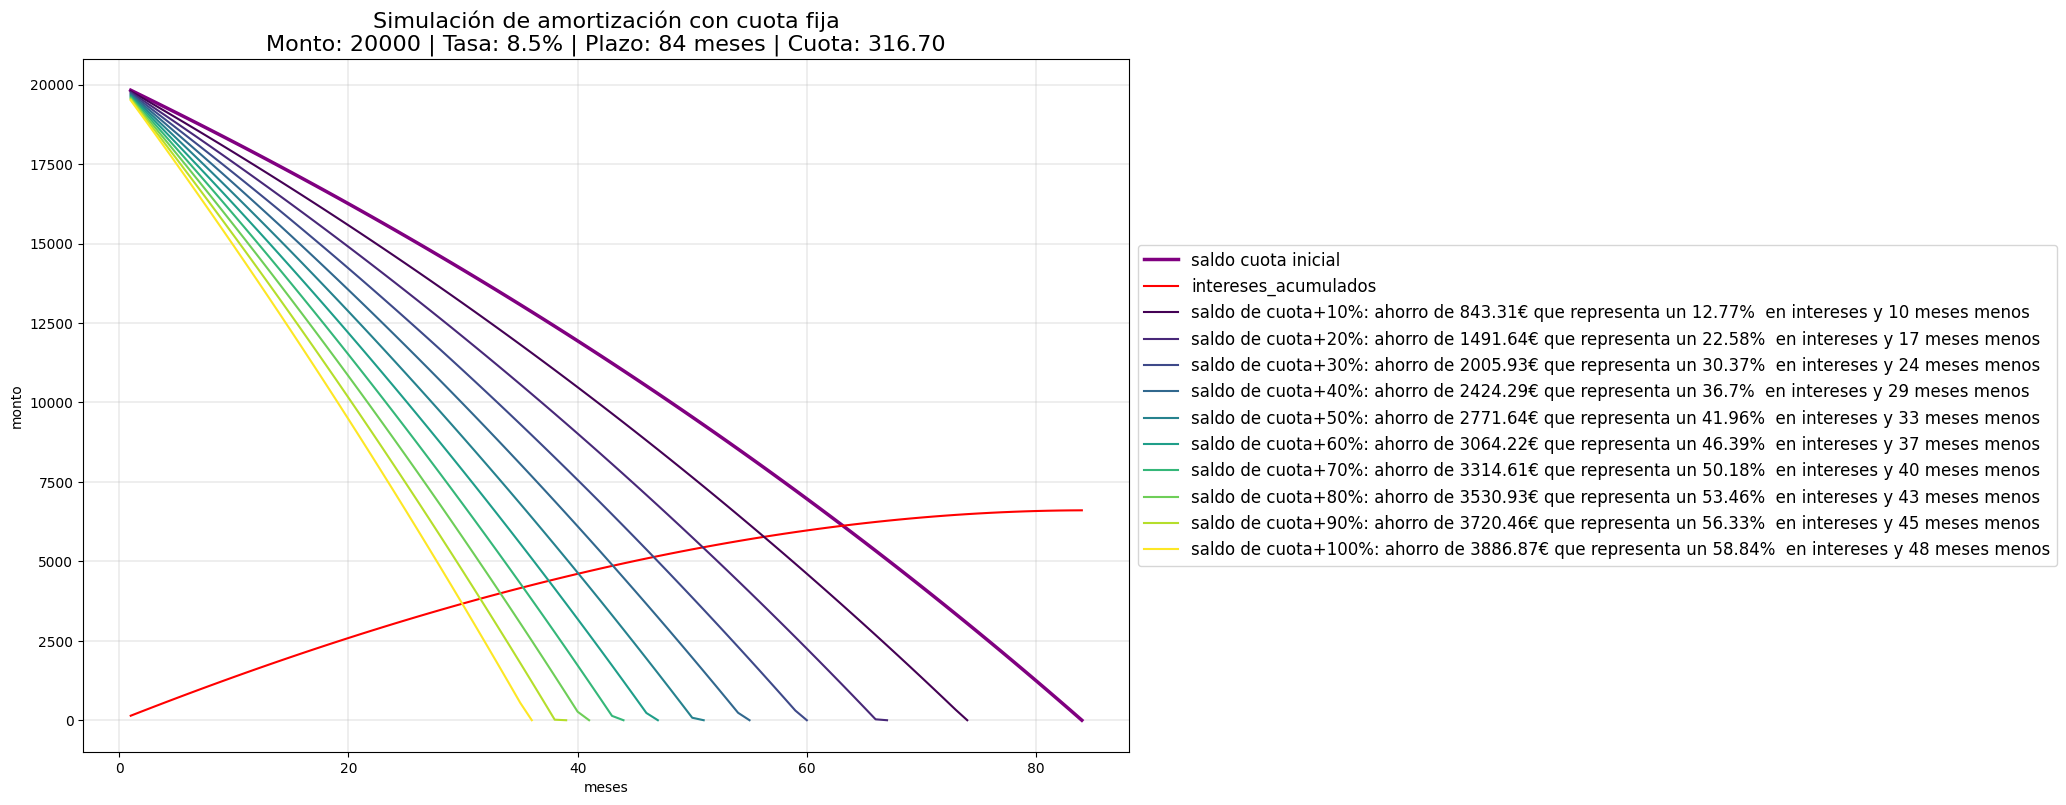

In [9]:
# Interes de compra de coche
TASA = 8.5
MONTO = 20000
MESES = 7*12

_, _ = pipeline(MONTO, TASA, MESES)

/var/folders/8c/_kn82sm11xg_1xzyn7clzt1w0000gn/T/ipykernel_56989/914131256.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')  # Puedes probar otros como 'viridis', 'coolwarm', etc.


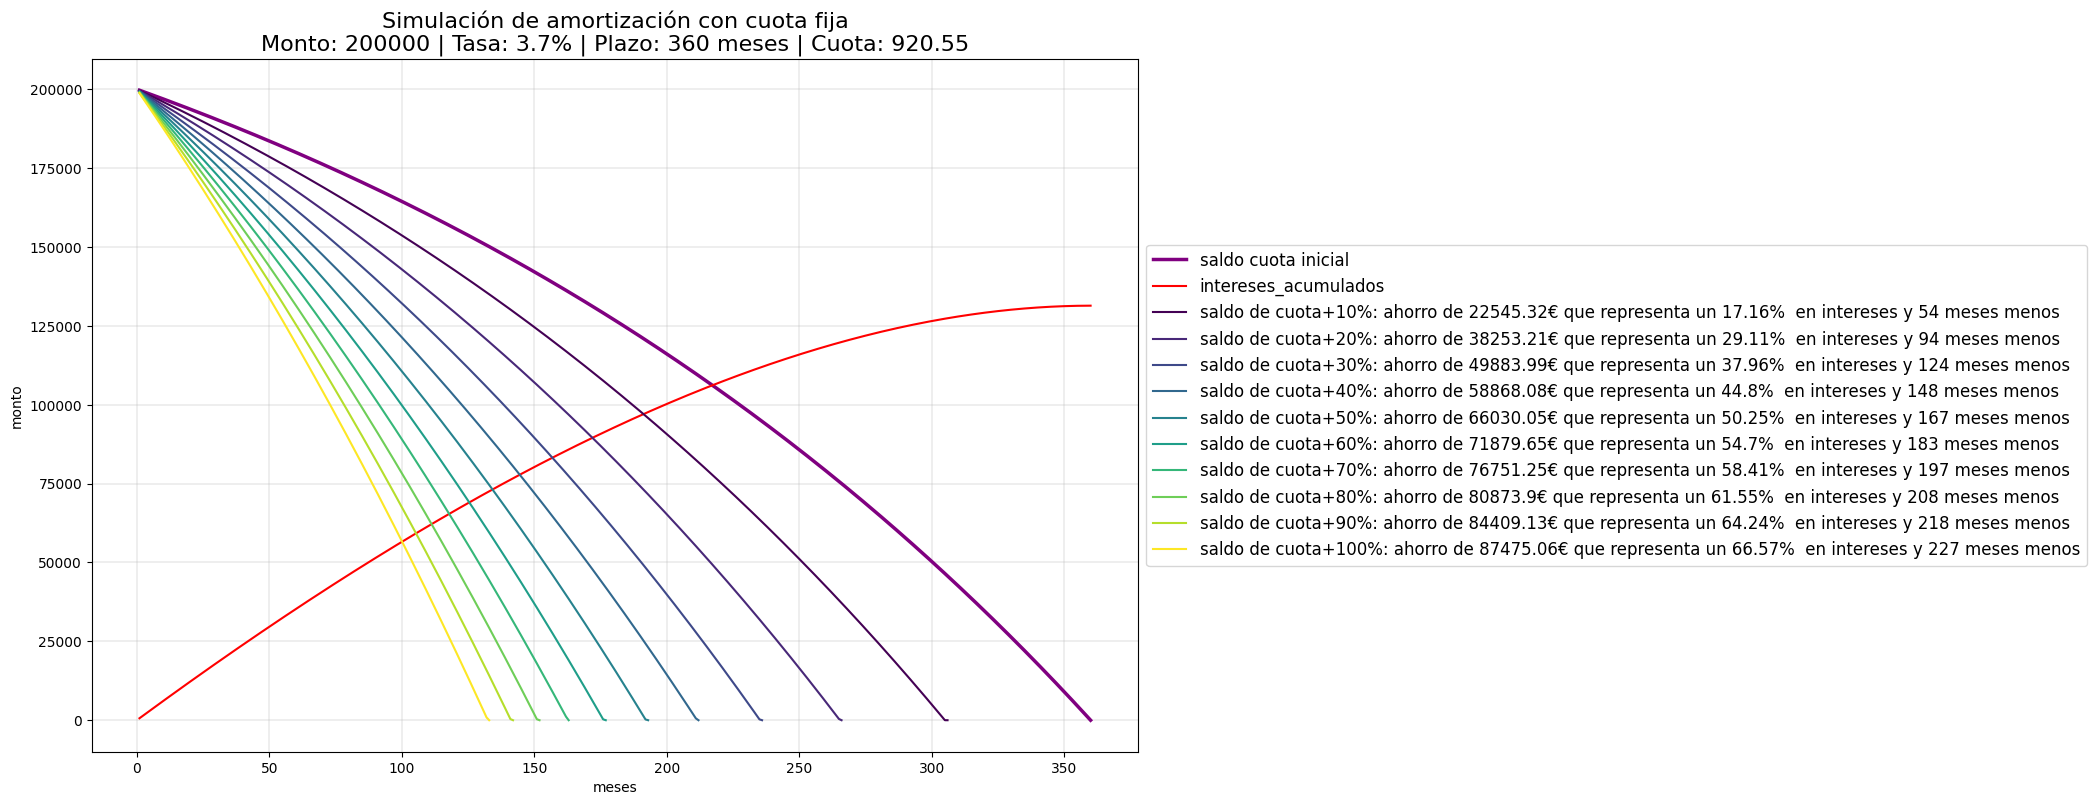

In [10]:
# Hipoteca fija
TASA = 3.7
MONTO = 200000
MESES = 30*12

_, _ = pipeline(MONTO, TASA, MESES)